In [1]:
# Read Shape files (.shp) with geopandas
# Get .shp files link for the correspondant area at
# http://download.geofabrik.de/ and place it in shape_files
import glob
import io
import math
import os
import zipfile

import dask
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import requests
from dask.distributed import Client
from modis_tools.auth import ModisSession
from modis_tools.granule_handler import GranuleHandler
from modis_tools.resources import CollectionApi, GranuleApi
from osgeo import gdal
from pymodis import downmodis
from pyproj import Proj

/home/helliuminati/anaconda3/envs/milestoneenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
url = "http://download.geofabrik.de/europe/netherlands/gelderland-latest-free.shp.zip"
extraction = "shape_files"
if not os.path.exists(extraction):
    os.makedirs(extraction)

response = requests.get(url)
if response.status_code == 200:
    zipfile = zipfile.ZipFile(io.BytesIO(response.content))
    zipfile.extractall(extraction)
    print("Shape files downloaded")
    print("Shape files are in shape_files")

KeyboardInterrupt: 

In [23]:
gdf = gpd.read_file("shape_files/gis_osm_natural_free_1.shp")
farthest_west = gdf.geometry.bounds["minx"].idxmin()

# Find the farthest east point
farthest_east = gdf.geometry.bounds["maxx"].idxmax()
farthest_north = gdf.geometry.bounds["maxy"].idxmax()
farthest_south = gdf.geometry.bounds["miny"].idxmin()
west_coordinates = gdf.loc[farthest_west, "geometry"].coords[0]
east_coordinates = gdf.loc[farthest_east, "geometry"].coords[0]
north_coordinates = gdf.loc[farthest_north, "geometry"].coords[0]
south_coordinates = gdf.loc[farthest_south, "geometry"].coords[0]
print("Farthest West Coordinates:", west_coordinates)
print("Farthest East Coordinates:", east_coordinates)
print("Farthest North Coordinates:", north_coordinates)
print("Farthest South Coordinates:", south_coordinates)
gdf.head()

Farthest West Coordinates: (5.0115545, 51.8170254)
Farthest East Coordinates: (6.8113423, 51.9661496)
Farthest North Coordinates: (5.867911, 52.5193333)
Farthest South Coordinates: (5.9325433, 51.7422767)


,osm_id,code,fclass,name,geometry
0,44049765,4121,tree,NaN,POINT (5.86162 51.83953)
1,45383662,4121,tree,NaN,POINT (6.23474 52.13157)
2,256125364,4101,spring,NaN,POINT (5.91609 52.17271)
3,402517876,4101,spring,NaN,POINT (5.95802 52.18598)
4,402699881,4101,spring,NaN,POINT (5.95648 52.17640)


In [24]:
"""""" """
Brief Intro: MODIS assumes the Earth is a sphere
with a R = 6.3781e6 m (6371007.181 m) radius.
The world is subdivided into 18 vertical tiles and 36 horizontal tiles.
each tile has 2400 cells of 500m x 500m.
For reference of these calculations refer to : https://gis.stackexchange.com/a/337575
"""
# Constants
CELLS = 2400
VERTICAL_TILES = 18
HORIZONTAL_TILES = 36
EARTH_RADIUS = 6371007.181
EARTH_WIDTH = 2 * math.pi * EARTH_RADIUS

# Calculate tile and cell sizes
TILE_WIDTH = EARTH_WIDTH / HORIZONTAL_TILES
TILE_HEIGHT = TILE_WIDTH
CELL_SIZE = TILE_WIDTH / CELLS


# Define a projection for the MODIS sinusoidal grid
MODIS_GRID = Proj(f"+proj=sinu +R={EARTH_RADIUS} +nadgrids=@null +wktext")

# Function to convert latitude and longitude to MODIS grid coordinates


def lat_lon_to_modis(lat, lon):
    # Use the MODIS_GRID projection to convert
    # latitude and longitude to x, y coordinates
    x, y = MODIS_GRID(lon, lat)

    # Calculate horizontal and vertical grid indices (h and v)
    h = (EARTH_WIDTH * 0.5 + x) / TILE_WIDTH
    v = -(EARTH_WIDTH * 0.25 + y - (VERTICAL_TILES - 0) * TILE_HEIGHT) / TILE_HEIGHT

    # Return the grid indices as integers
    return int(h), int(v)


# Example usage
x, y = lat_lon_to_modis(51.7422767, 5.9325433)
# 5.0115545, 51.8170254
# 6.8113423, 51.9661496
# 5.9325433, 51.7422767
print(x)
print(y)

18
3


In [2]:
# Define the parameters
product = "MOD09A1.061"  # e.g., 'MOD09A1'
tiles = "h18v03"  # e.g., 'h17v03,h18v03'

# Create the NIR directory if it doesn't exist
if not os.path.exists("NIR"):
    os.makedirs("NIR")

output_directory = "./NIR/"  # Output Directory
day = "2014-01-01"  # Starting Day
endDate = "2022-12-31"  # Ending Day

# Initialize the downloader
modis_downloader = downmodis.downModis(
    product=product,
    tiles=tiles,
    user="",  # Change to your username
    password="",  # Change to your password
    destinationFolder=output_directory,
    today=day,
    enddate=endDate,
    timeout=60,
    checkgdal=False,
)

# Connect to the server
modis_downloader.connect(ncon=40)

# Download the data for all days in the range
done = False
while done is False:
    try:
        print("Started...")
        modis_downloader.downloadsAllDay()
        done = True
    except Exception as e:
        print(e)

Started...


In [1]:
def download_granules(
    username: str,
    password: str,
    start_date: str,
    end_date: str,
    bounding_box: list[float],
    path: str,
) -> None:
    """
    Download MODIS granules from the specified date range and bounding box.

    Args:
        username (str): The username for authentication.
        password (str): The password for authentication.
        start_date (str): The start date of the granules to download.
        end_date (str): The end date of the granules to download.
        bounding_box (List[float]):
        The bounding box coordinates
        [min_longitude, min_latitude, max_longitude, max_latitude].
        path (str): The path to save the downloaded granules.

    Returns:
        None
    """
    # Authenticate a session
    session = ModisSession(username=username, password=password)

    # Query the MODIS catalog for collections
    collection_client = CollectionApi(session=session)
    collections = collection_client.query(short_name="MOD09A1", version="061")
    granule_client = GranuleApi.from_collection(collections[0], session=session)

    # Query the granules
    granules = granule_client.query(
        start_date=start_date, end_date=end_date, bounding_box=bounding_box
    )

    # Download the granules
    GranuleHandler.download_from_granules(
        one_or_many_granules=granules, modis_session=session, threads=-2, path=path
    )


download_granules(
    "", "", "2015-01-01", "2022-12-31", [4.1968, 51.5190, 7.6300, 52.7330], "./NIR/"
)

In [4]:
def calculate_ndvi(
    input_file: str, output_path: str, target_crs: str, src_crs: str
) -> None:
    """Calculate NDVI and reproject the dataset.

    Args:
        input_file (str): Path to the input file.
        output_path (str): Path to the output file.
        target_crs (str): Target CRS (Coordinate Reference System).
        src_crs (str): Source CRS.

    Returns:
        None
    """
    # Open the input file in read-only mode using GDAL
    try:
        dataset: gdal.Dataset = gdal.Open(input_file, gdal.GA_ReadOnly)

        # Open the first subdataset in the dataset
        # which represents the Near-Infrared (NIR) values
        subdataset_RED: gdal.Dataset = gdal.Open(
            dataset.GetSubDatasets()[0][0], gdal.GA_ReadOnly
        )

        # Read the Red (RED) values from the first band of the NIR subdataset
        RED_VALUES: any = subdataset_RED.GetRasterBand(1).ReadAsArray()

        # Open the second subdataset in the dataset
        # which represents the Red (RED) values
        subdataset_NIR: gdal.Dataset = gdal.Open(
            dataset.GetSubDatasets()[1][0], gdal.GA_ReadOnly
        )

        # Read the NIR values from the first band of the RED subdataset
        NIR_VALUES: any = subdataset_NIR.GetRasterBand(1).ReadAsArray()
    except Exception as e:
        print(e)

    """
    Calculate the Normalized Difference Vegetation Index (NDVI) 
    using the NIR and RED values
    """
    NDVI_VALUES: any = (NIR_VALUES - RED_VALUES) / (NIR_VALUES + RED_VALUES)
    """
    Create a new in-memory dataset with the same size 
    and data type as the NIR subdataset
    """
    new_dataset: gdal.Dataset = gdal.GetDriverByName("MEM").Create(
        "",
        subdataset_NIR.RasterXSize,
        subdataset_NIR.RasterYSize,
        1,
        subdataset_NIR.GetRasterBand(1).DataType,
    )

    # Set the geotransform and projection of the new dataset to match the NIR subdataset
    new_dataset.SetGeoTransform(subdataset_NIR.GetGeoTransform())
    new_dataset.SetProjection(subdataset_NIR.GetProjection())

    # Get the first band of the new dataset
    new_band: gdal.Band = new_dataset.GetRasterBand(1)

    # Write the NDVI values to the new dataset
    new_band.WriteArray(NDVI_VALUES)

    # Reproject the new dataset to the target coordinate reference system (CRS)
    # save it as a GeoTIFF
    gdal.Warp(
        output_path, new_dataset, dstSRS=target_crs, srcSRS=src_crs, format="GTiff"
    )

    # Set the datasets to None to release the resources
    new_dataset = None
    dataset = None

    # Print a message indicating that the reprojection is done
    print("Reprojected")

In [6]:
output_directory = "./NIR/"
files = glob.glob(os.path.join(output_directory, "MOD09A1*.hdf"))
files.sort()
for file in files:
    # Get Day Value From Filename
    # Given filename for example is MOD09A1.A2023217.h18v03.061.2023226041025.hdf
    # We want to get the day value of the file
    # So we split the filename on the period and then on the underscore
    # Then we take the second item in the list which is the day value
    # We then convert it to an integer
    # We convert it using datetime using year and day
    # Subtract 1 from the day value to get the correct date
    dateValue = str(file.split("/")[-1].split(".")[1])
    yearValue = int(file.split("/")[-1].split(".")[1][1:5])
    dayValue = int(file.split("/")[-1].split(".")[1][5:])
    output_str = os.path.join("./NDVI_Images", "NDVI_" + dateValue[1:] + ".tif")
    calculate_ndvi(
        file,
        output_str,
        "EPSG:4326",
        "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +R=6371007.181 +units=m +k=0.0001 +no_defs",
    )

/tmp/ipykernel_8354/332684817.py:42: RuntimeWarning: divide by zero encountered in divide
  NDVI_VALUES: any = (NIR_VALUES - RED_VALUES) / (NIR_VALUES + RED_VALUES)
/tmp/ipykernel_8354/332684817.py:42: RuntimeWarning: invalid value encountered in divide
  NDVI_VALUES: any = (NIR_VALUES - RED_VALUES) / (NIR_VALUES + RED_VALUES)


Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Reprojected
Repr

UnboundLocalError: cannot access local variable 'NIR_VALUES' where it is not associated with a value

In [6]:
def plot_ndvi_image(output_path: str, shapefile: str) -> None:
    """
    Plot the GeoTIFF data and shapefile boundary on a map.

    Parameters:
    output_path (str): Path to the output GeoTIFF file.

    Returns:
    None
    """
    # Open the GeoTIFF dataset
    geotiff_dataset: gdal.Dataset = gdal.Open(output_path)

    # Read the shapefile
    gdf: gpd.GeoDataFrame = gpd.read_file(shapefile)

    # Read the reprojected GeoTIFF dataset
    new_band: gdal.Band = geotiff_dataset.GetRasterBand(1)
    geotiff_data: np.ndarray = new_band.ReadAsArray()

    # Get the geospatial information (geotransform and CRS) from the reprojected dataset
    geotransform: tuple[
        float, float, float, float, float, float
    ] = geotiff_dataset.GetGeoTransform()

    # Define the extent of the plot using the geotransform information
    x_min: float = geotransform[0]
    y_max: float = geotransform[3]
    x_max: float = x_min + geotransform[1] * geotiff_data.shape[1]
    y_min: float = y_max + geotransform[5] * geotiff_data.shape[0]

    # Get the boundary of the shapefile
    xmin, ymin, xmax, ymax = gdf.total_bounds

    # Create the plot
    # Get boundary as unary_union to convert all Polygons into one Polygon
    boundary = gdf.unary_union

    # Create a GeoDataFrame with the boundary geometry
    boundary_gdf: gpd.GeoDataFrame = gpd.GeoDataFrame(geometry=[boundary])

    # Initialize the plot
    plt.figure(figsize=(10, 10))

    # Plot the GeoTIFF data
    plt.imshow(
        geotiff_data,
        cmap="RdYlGn",
        extent=[x_min, x_max, y_min, y_max],
        vmin=-1,
        vmax=1,
    )

    # Plot the boundary of the shapefile
    boundary_gdf.boundary.plot(
        ax=plt.gca(), facecolor="none", edgecolor="r", alpha=0.1, aspect=1, linewidth=1
    )

    # Add colorbar and labels
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.colorbar(label="NDVI")
    plt.title("Reprojected NDVI Image")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    # Display the plot
    # plt.show()

    # Close the GeoTIFF dataset
    geotiff_dataset = None

In [ ]:
# Define the directory where the images are located
image_directory = "./NDVI_Images"

# Get a list of all the TIFF files in the directory and sort them
files = glob.glob(os.path.join(image_directory, "*.tif"))
files.sort()

# Iterate over the first 5 files in the list
for file in files[0:5]:
    # Call the plot_ndvi_image function with the current file as the output path
    # and the shapefile path as "shape_files/gis_osm_natural_free_1.shp"
    plot_ndvi_image(
        output_path=file, shapefile="shape_files/gis_osm_natural_free_1.shp"
    )

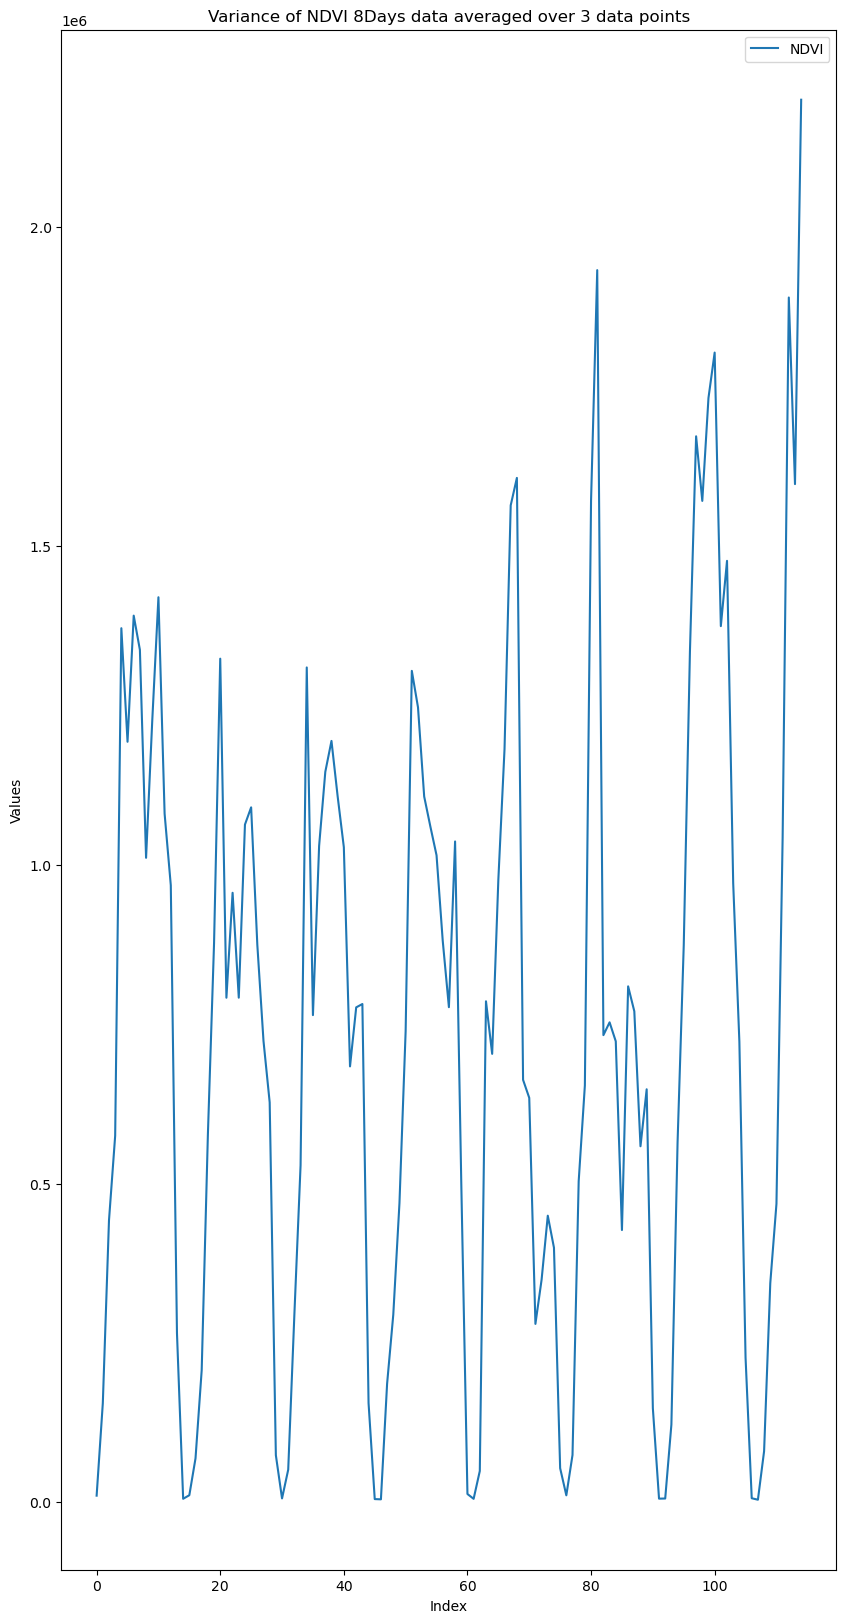

CPU times: user 8.51 s, sys: 4.51 s, total: 13 s
Wall time: 15.9 s


In [35]:
%%time
def averageNDVI(output_path: list[str]) -> np.ndarray:
    """
    Calculate the average NDVI from a list of output paths.

    Args:
        output_path: A list of output file paths.

    Returns:
        The average NDVI as a numpy array.
    """
    values = []

    # Iterate over each output file path
    for path in output_path:
        # Open the geotiff dataset
        geotiff_dataset: gdal.Dataset = gdal.Open(path)

        # Get the first band (NDVI band)
        band_ndvi: gdal.Band = geotiff_dataset.GetRasterBand(1)

        # Read the NDVI values as an array
        values.append(band_ndvi.ReadAsArray())

    # Calculate the average NDVI
    average_ndvi = np.average(values, axis=0)
    return average_ndvi


# Set the output directory and find all NDVI files in the directory
output_directory: str = "./NDVI_Images/"
files: list[str] = glob.glob(os.path.join(output_directory, "NDVI*.tif"))
files.sort()

values = []

# Iterate over the files in groups of 3
for i in range(0, len(files), 3):
    # Calculate the average NDVI for the current group of files
    average_ndvi = averageNDVI(files[i : i + 3])

    # Append the variance of the average NDVI to the list of values
    values.append(np.var(average_ndvi))

# Create indices for the plot
indices = range(len(values))

# Create a plot of the variance of the NDVI values
plt.figure(figsize=(10, 20))
plt.plot(indices, values, label="NDVI")
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Variance of NDVI 8Days data averaged over 3 data points")
plt.legend()
plt.show()

Dask Tutorial

In This tutorial we will try to apply Dask to our methodologies.

Dask is a parallel and distributed computing library that scales the existing Python and PyData ecosystem.

Dask can scale up to your full laptop capacity and out to a cloud cluster.


In [9]:
client = Client(n_workers=4)

/home/helliuminati/anaconda3/envs/milestoneenv/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40959 instead
  warnings.warn(


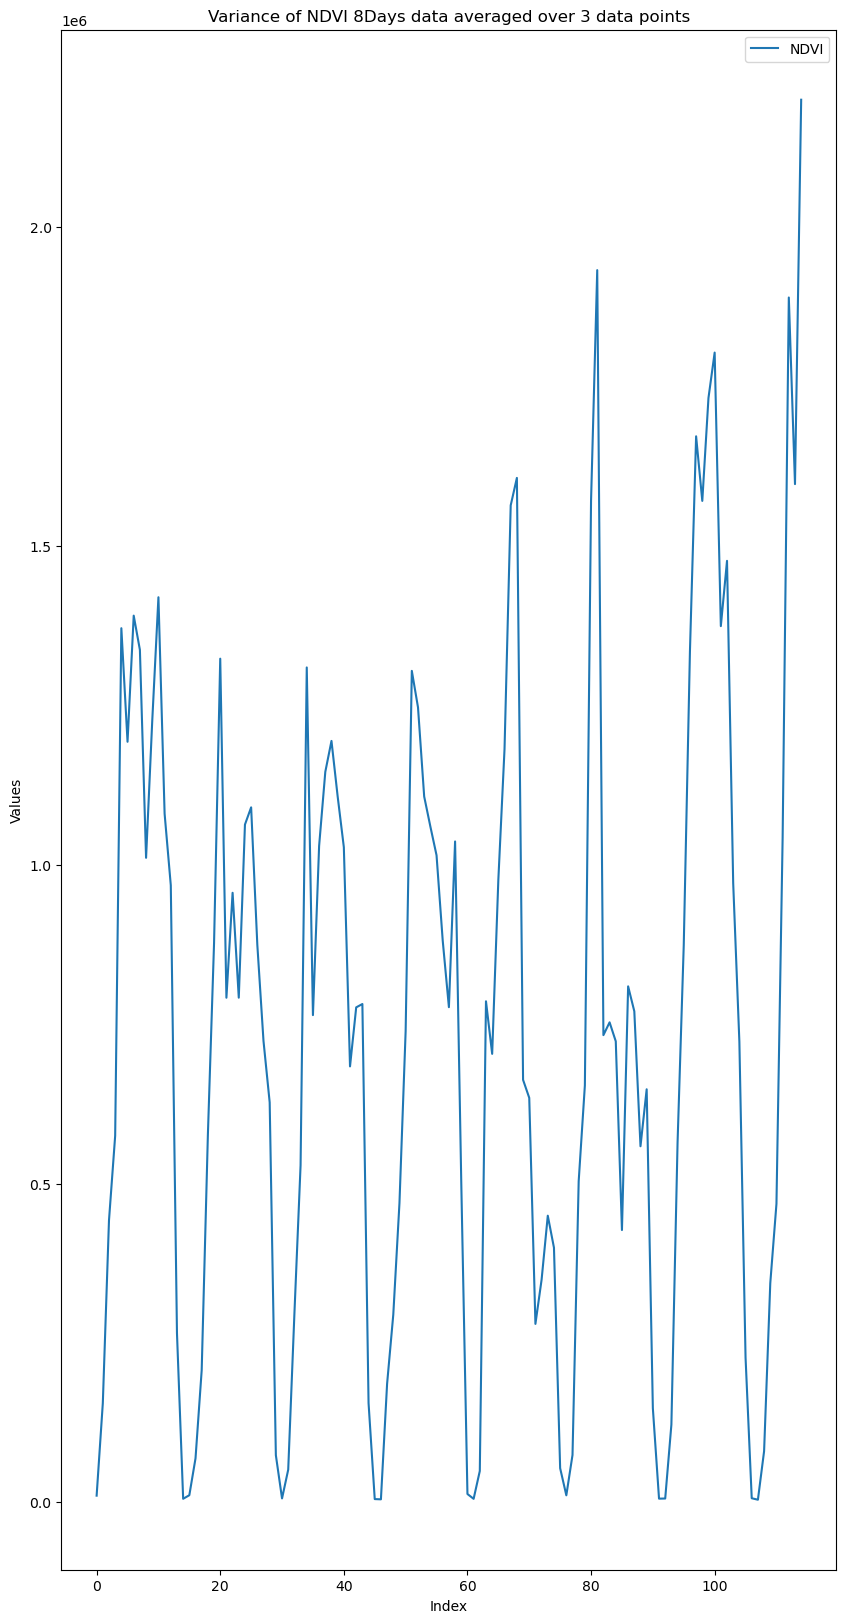

CPU times: user 4.16 s, sys: 429 ms, total: 4.59 s
Wall time: 19.3 s


In [44]:
def averageNDVI(output_path: list[str]) -> np.ndarray:
    """
    Calculate the average NDVI from a list of output paths.

    Args:
        output_path: A list of output file paths.

    Returns:
        The average NDVI as a numpy array.
    """
    values = []

    # Iterate over each output file path
    for path in output_path:
        # Open the geotiff dataset
        geotiff_dataset: gdal.Dataset = gdal.Open(path)

        # Get the first band (NDVI band)
        band_ndvi: gdal.Band = geotiff_dataset.GetRasterBand(1)

        # Read the NDVI values as an array
        values.append(band_ndvi.ReadAsArray())

    # Calculate the average NDVI
    average_ndvi = np.average(values, axis=0)
    return average_ndvi


def wrapper():
    output_directory: str = "./NDVI_Images/"
    files: list[str] = glob.glob(os.path.join(output_directory, "NDVI*.tif"))
    files.sort()

    values = []

    # Iterate over the files in groups of 3
    for i in range(0, len(files), 3):
        # Calculate the average NDVI for the current group of files
        z = averageNDVI(files[i : i + 3])

        average_ndvi = z.compute()

        # Append the variance of the average NDVI to the list of values
        values.append(np.var(average_ndvi))

    # Create indices for the plot

    return np.array(values)


z = wrapper()
result = dask.compute(z)
indices = range(len(result))
# Create a plot of the variance of the NDVI values
plt.figure(figsize=(10, 20))
plt.plot(result[0], label="NDVI")
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Variance of NDVI 8Days data averaged over 3 data points")
plt.legend()
plt.show()

Let's Take a Look at Both User Metrics (With Dask, Without Dask)<br>
<code>
- Without Dask:<br>
    - CPU times: user 8.51 s, sys: 4.51 s, total: 13 s<br>
    - Wall time: 15.9 s
</code>
<br>
<code>
- With Dask: <br>
    - CPU times: user 4.16 s, sys: 429 ms, total: 4.59 s<br>
    - Wall time: 19.3 s<br>
</code>

A Close look, we see that total execution time using dask is far more better than total execution time without dask:<br> `(4.59 seconds : 13 seconds)`<br>
This is due to parallelism and distributed calculations using dask which is a lot useful<br>
Following will be acquiring data using Dask from modis servers.
